In [6]:
import numpy as np
from itertools import product
import pandas as pd
from pykalman import KalmanFilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Filter out patients with fewer than 3 records
patient_record_counts = data_cleaned['usubjid'].value_counts()
patients_to_keep = patient_record_counts[patient_record_counts >= 3].index
data_cleaned = data_cleaned[data_cleaned['usubjid'].isin(patients_to_keep)]

# Preprocess the data 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Split the data into train and test sets by patients
patients = data_cleaned['usubjid'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

train_data = data_cleaned[data_cleaned['usubjid'].isin(train_patients)]
test_data = data_cleaned[data_cleaned['usubjid'].isin(test_patients)]

# Define the grid of parameters
initial_state_means = [np.zeros(len(features)), np.ones(len(features))]
transition_matrices = [np.eye(len(features)), 0.95 * np.eye(len(features))]
observation_matrices = [np.eye(len(features)), 0.9 * np.eye(len(features))]
process_noise_covariances = [0.01 * np.eye(len(features)), 0.1 * np.eye(len(features))]
observation_noise_covariances = [0.1 * np.eye(len(features)), 0.5 * np.eye(len(features))]
initial_covariances = [0.1 * np.eye(len(features)), np.eye(len(features))]

# Weights for the combined metric
alpha = 0.5  # Weight for residual standard deviation
beta = 0.5   # Weight for covariance matrix difference

# Grid search
best_combined_score = np.inf
best_params = None

# Lists to store all results
results = []
residual_means = []
residual_stds = []
covariance_diffs = []
combined_metrics = []

# Train on the training data, patient by patient
for param_combination in product(initial_state_means, transition_matrices, observation_matrices, process_noise_covariances, observation_noise_covariances, initial_covariances):
    initial_mean, A, C, Q, R, P_0 = param_combination
    # Initialize the Kalman Filter with fixed parameters
    kf = KalmanFilter(
    initial_state_mean=initial_mean,
    transition_matrices=A,
    observation_matrices=C,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_covariance=P_0,
    n_dim_obs=len(features),
    n_dim_state=len(features)
    )
    for i in range(5):
        for usubjid, group in train_data.groupby('usubjid'):
            # Shuffle and sort by 'ady_dna'
            # group = group.sample(frac=1, random_state=42).sort_values('ady_dna')
            
            # Extract features and target
            X_train = group[features].values
            y_train = group[target].values
            try:
                # Train the filter using EM
                kf = kf.em(X_train, n_iter=1)
            except Exception as e:
                print(f"An error occurred while training for patient {usubjid}: {e}")
                continue  # Skip this patient and proceed to the next one
    X_test = test_data[features].values
    y_test = test_data[target].values

    # Filter the test data
    state_means, state_covariances = kf.filter(X_test)
    
    # Metric 1: Residual Analysis
    residuals = X_test - state_means
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    # Metric 2: Covariance Matrix Stability
    if len(covariance_diffs) > 0:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
    else:
        covariance_diffs.append(0)  # No comparison for the first iteration
    
    prev_covariance_matrix = state_covariances
    
    # Store the current configuration and results
    results.append({
        'initial_state_mean': initial_mean,
        'transition_matrix': A,
        'observation_matrix': C,
        'process_noise_covariance': Q,
        'observation_noise_covariance': R,
        'initial_covariance': P_0,
        'residual_mean': residual_mean,
        'residual_std': residual_std,
        'covariance_diff': covariance_diffs[-1],
    })
# Normalize after collecting all values
scaler = MinMaxScaler()
normalized_residual_stds = scaler.fit_transform(np.array(residual_stds).reshape(-1, 1)).flatten()
normalized_covariance_diffs = scaler.fit_transform(np.array(covariance_diffs).reshape(-1, 1)).flatten()

# Calculate combined metrics
for i in range(len(results)):
    combined_metric = alpha * normalized_residual_stds[i] + beta * normalized_covariance_diffs[i]
    combined_metrics.append(combined_metric)
    
    # Update the best parameters based on the combined metric
    if combined_metric < best_combined_score:
        best_combined_score = combined_metric
        best_params = results[i]

    print(f"Residual Mean = {results[i]['residual_mean']:.4f}, Residual Std Dev = {results[i]['residual_std']:.4f}, Covariance Diff = {results[i]['covariance_diff']:.4f}, Combined Metric = {combined_metric:.4f}")

# Store the best parameters
print("\nBest Parameters Found Based on Combined Metric:")
print(best_params)


Residual Mean = 0.0526, Residual Std Dev = 21.2438, Covariance Diff = 0.0000, Combined Metric = 0.0494
Residual Mean = 0.0096, Residual Std Dev = 31.0241, Covariance Diff = 26537.6378, Combined Metric = 0.1686
Residual Mean = 0.0517, Residual Std Dev = 24.1422, Covariance Diff = 3103.6679, Combined Metric = 0.0765
Residual Mean = 0.0139, Residual Std Dev = 39.8589, Covariance Diff = 83542.6412, Combined Metric = 0.3334
Residual Mean = 0.0902, Residual Std Dev = 26.1715, Covariance Diff = 120645.2813, Combined Metric = 0.2953
Residual Mean = 0.0501, Residual Std Dev = 17.3455, Covariance Diff = 16097.5340, Combined Metric = 0.0481
Residual Mean = 0.1116, Residual Std Dev = 34.7297, Covariance Diff = 35608.7203, Combined Metric = 0.2120
Residual Mean = 0.0465, Residual Std Dev = 23.0111, Covariance Diff = 15212.7791, Combined Metric = 0.0890
Residual Mean = -14.5141, Residual Std Dev = 31.3422, Covariance Diff = 28084.3514, Combined Metric = 0.1736
Residual Mean = -14.5675, Residual Std 

# Save and export results

In [7]:
import os
import json
import matplotlib.pyplot as plt
# Create an output directory if it doesn't exist
output_dir = "../Outputs"

# Change accordingly
experiments_log = "80%train_50iter_commetrics_patient_level_full"
path = os.path.join(output_dir, experiments_log)

Best parameters saved to ../Outputs/80%train_50iter_commetrics_patient_level_full/best_parameters.json


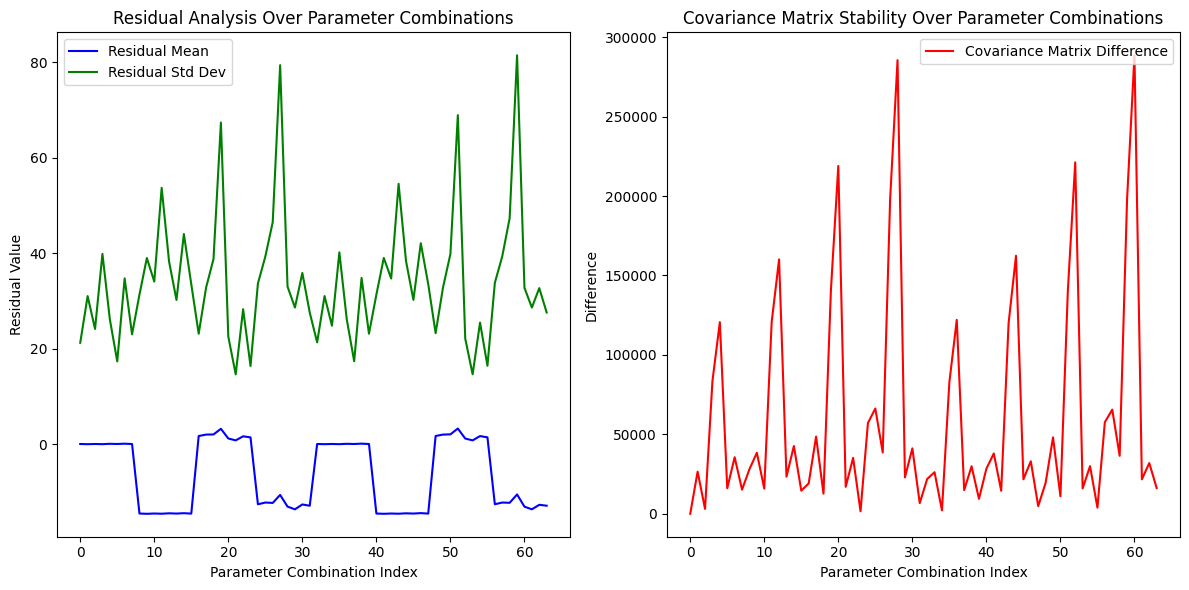

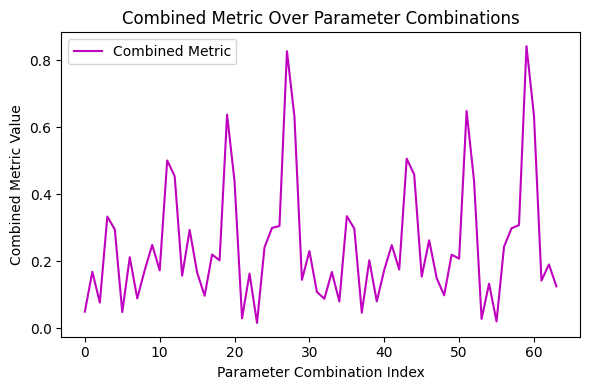

Best parameters saved to ../Outputs/80%train_50iter_commetrics_patient_level_full/best_parameters.json
All results saved to ../Outputs/80%train_50iter_commetrics_patient_level_full/all_results.csv
Plots saved to ../Outputs/80%train_50iter_commetrics_patient_level_full/residual_covariance_plots.png and ../Outputs/80%train_50iter_commetrics_patient_level_full/combined_metric_plot.png


In [8]:
# Ensure the directory exists
os.makedirs(path, exist_ok=True)

# Assuming `best_params`, `results`, `residual_means`, `residual_stds`, `covariance_diffs`, and `combined_metrics` are already calculated

# Define file paths
results_csv_file = os.path.join(path, "all_results.csv")
residual_plot_file = os.path.join(path, "residual_covariance_plots.png")
combined_metric_plot_file = os.path.join(path, "combined_metric_plot.png")

# # Save best parameters to a CSV file
# best_params_file = os.path.join(path, "best_parameters.csv")
# best_params_df = pd.DataFrame([best_params])
# best_params_df.to_csv(best_params_file, index=False)

# Convert numpy arrays to lists
best_params_serializable = {k: v.tolist() for k, v in best_params.items()}
best_params_file = os.path.join(path, "best_parameters.json")

# Save the best parameters to a JSON file
with open(best_params_file, 'w') as json_file:
    json.dump(best_params_serializable, json_file, indent=4)

print(f"Best parameters saved to {best_params_file}")


# Save all results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(results_csv_file, index=False)

# Visualize and save the metrics

# Plot Residual Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residual_means, 'b-', label='Residual Mean')
plt.plot(residual_stds, 'g-', label='Residual Std Dev')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Residual Value')
plt.title('Residual Analysis Over Parameter Combinations')
plt.legend()

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, 'r-', label='Covariance Matrix Difference')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Difference')
plt.title('Covariance Matrix Stability Over Parameter Combinations')
plt.legend()

# Save the residual and covariance plots
plt.tight_layout()
plt.savefig(residual_plot_file)

plt.show()

# Plot Combined Metric
plt.figure(figsize=(6, 4))
plt.plot(combined_metrics, 'm-', label='Combined Metric')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Combined Metric Value')
plt.title('Combined Metric Over Parameter Combinations')
plt.legend()

# Save the combined metric plot
plt.tight_layout()
plt.savefig(combined_metric_plot_file)

plt.show()

print(f"Best parameters saved to {best_params_file}")
print(f"All results saved to {results_csv_file}")
print(f"Plots saved to {residual_plot_file} and {combined_metric_plot_file}")

# Retraining and optimize the iteration steps

In [ ]:
import numpy as np
import os
import json
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
# Create an output directory if it doesn't exist
output_dir = "../Outputs"

# Change accordingly
experiments_log = "80%train_50iter_commetrics_patient_level_full"
path = os.path.join(output_dir, experiments_log)

In [ ]:
best_params_file = os.path.join(path, "best_parameters.json")
# Function to read JSON file
def read_json_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except json.JSONDecodeError:
        print("Error: The file could not be decoded. Ensure it's a valid JSON file.")

best_params = read_json_file(best_params_file)

In [ ]:
initial_mean = np.array(best_params["initial_state_mean"])
A = np.array(best_params["transition_matrix"])
C = np.array(best_params["observation_matrix"])
Q = np.array(best_params["process_noise_covariance"])
R = np.array(best_params["observation_noise_covariance"])
P_0 = np.array(best_params["initial_covariance"])

In [ ]:
# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Filter out patients with fewer than 3 records
patient_record_counts = data_cleaned['usubjid'].value_counts()
patients_to_keep = patient_record_counts[patient_record_counts >= 3].index
data_cleaned = data_cleaned[data_cleaned['usubjid'].isin(patients_to_keep)]

# Preprocess the data 
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Split the data into train and test sets by patients
patients = data_cleaned['usubjid'].unique()
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

train_data = data_cleaned[data_cleaned['usubjid'].isin(train_patients)]
test_data = data_cleaned[data_cleaned['usubjid'].isin(test_patients)]

Iteration 1: Residual Mean = 1.4501, Residual Std Dev = 16.9147
Iteration 2: Residual Mean = 1.5782, Residual Std Dev = 20.0110
Iteration 2: Covariance Matrix Difference = 8909.0051
Iteration 3: Residual Mean = 1.6749, Residual Std Dev = 22.5091
Iteration 3: Covariance Matrix Difference = 4838.2658
Iteration 4: Residual Mean = 1.7160, Residual Std Dev = 24.3079
Iteration 4: Covariance Matrix Difference = 2703.9576
Iteration 5: Residual Mean = 1.7089, Residual Std Dev = 25.4710
Iteration 5: Covariance Matrix Difference = 1388.3910
Iteration 6: Residual Mean = 1.6701, Residual Std Dev = 26.1110
Iteration 6: Covariance Matrix Difference = 464.1297
Iteration 7: Residual Mean = 1.6147, Residual Std Dev = 26.3800
Iteration 7: Covariance Matrix Difference = 180.0310
Iteration 8: Residual Mean = 1.5531, Residual Std Dev = 26.4026
Iteration 8: Covariance Matrix Difference = 592.8568
Iteration 9: Residual Mean = 1.4908, Residual Std Dev = 26.2646
Iteration 9: Covariance Matrix Difference = 871.6

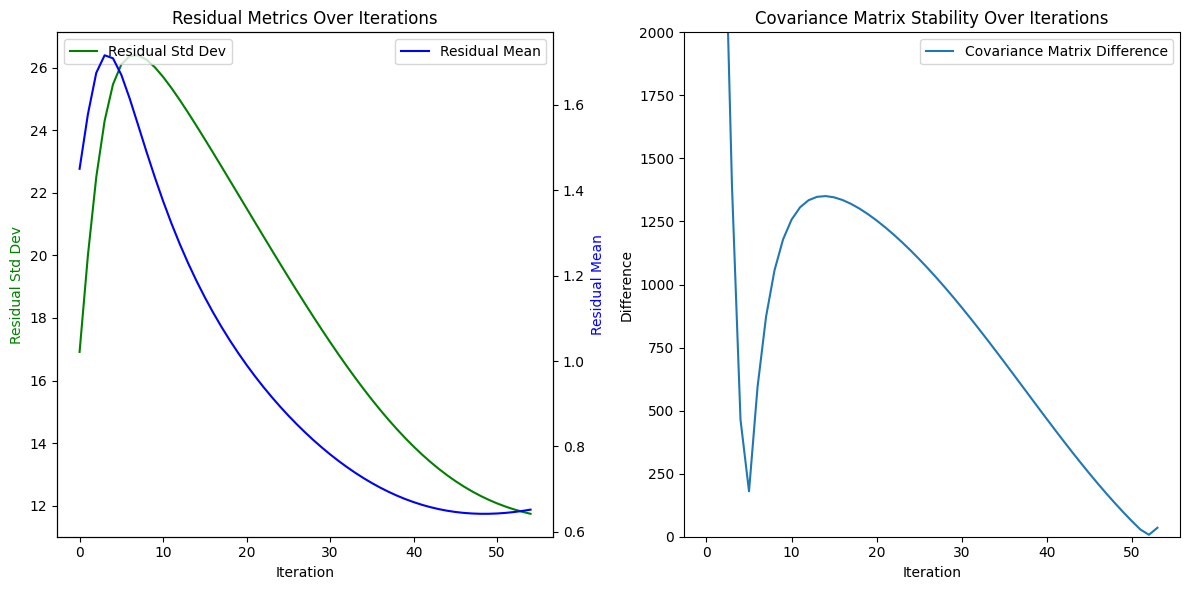

In [ ]:
kf = KalmanFilter(
initial_state_mean=initial_mean,
transition_matrices=A,
observation_matrices=C,
transition_covariance=Q,
observation_covariance=R,
initial_state_covariance=P_0,
n_dim_obs=len(features),
n_dim_state=len(features)
)
# Estimate the Kalman Filter parameters using EM algorithm and track convergence metrics
residual_means = []
residual_stds = []
covariance_diffs = []
prev_covariance_matrix = None

for i in range(55):
    for usubjid, group in train_data.groupby('usubjid'):
        # Shuffle and sort by 'ady_dna'
        # group = group.sample(frac=1, random_state=42).sort_values('ady_dna')
        
        # Extract features and target
        X_train = group[features].values
        y_train = group[target].values
        
        try:
            # Train the filter using EM
            kf = kf.em(X_train, n_iter=1)
        except Exception as e:
            print(f"An error occurred while training for patient {usubjid}: {e}")
            continue  # Skip this patient and proceed to the next one
    

    # test on validation dataset (*)
    X_test = test_data[features].values
    y_test = test_data[target].values

    state_means, state_covariances = kf.filter(X_test)
    
    # Calculate residuals
    residuals = X_test - state_means
    
    # Metric 1: Residual Analysis
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    print(f"Iteration {i+1}: Residual Mean = {residual_mean:.4f}, Residual Std Dev = {residual_std:.4f}")
    
    # Metric 2: Covariance Matrix Stability
    if prev_covariance_matrix is not None:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
        print(f"Iteration {i+1}: Covariance Matrix Difference = {covariance_diff:.4f}")
    prev_covariance_matrix = state_covariances

# Final Filter Application
state_means, state_covariances = kf.filter(X_test)

# Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Residual Std Dev with Residual Mean on a secondary Y-axis
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(residual_stds, 'g-', label='Residual Std Dev')
ax2.plot(residual_means, 'b-', label='Residual Mean')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual Std Dev', color='g')
ax2.set_ylabel('Residual Mean', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Residual Metrics Over Iterations')

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, label='Covariance Matrix Difference')
plt.ylim(0, 2000)
plt.title('Covariance Matrix Stability Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Use the state means for predictions
predicted_allosure = state_means[:, 1]
predicted_allomap = state_means[:, 0]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78       357
         1.0       0.44      0.37      0.40       147

    accuracy                           0.68       504
   macro avg       0.60      0.59      0.59       504
weighted avg       0.66      0.68      0.67       504

Confusion Matrix:
[[287  70]
 [ 92  55]]
AUC: 0.6233541035461804
Accuracy: 0.6785714285714286


# Export

In [ ]:
iteration = str(55)
patients_records = "full" # full vs partial (1)
model_name = path.split("/")[-1] + "_" + iteration + "_" + patients_records + ".pkl"

In [ ]:
import joblib

model_directory = "../models"
model_path = os.path.join(model_directory, model_name)
# Save the model to a file
joblib.dump(kf, model_path)

['../models/80%train_50iter_commetrics_patient_level_55_partial.pkl']